In [7]:
import pandas as pd
import numpy as np
import xarray as xr

from importlib import reload
import sys
sys.path.append('/home/students/4302001/arctic-connectivity/tools')
sys.path.append('/Users/daanreijnders/surfdrive/Thesis/repo/tools')
import plot
import lifeline
import community
import fieldsetter
import advectParticles

In [41]:
with open('temp/graph_rcp_P3590x590_S2000-1-9_D30_DT20_ODT12_LAT60.1-89.9_LON-179.9-179.9.tree') as treeFile:
    tree = treeFile.read().split('\n')
codelength = float(tree[0].split(' ')[3])
header = tree[1].split(' ')[1:]
body = [line.split(' ') for line in tree[2:] if line is not '']
communityDF = pd.DataFrame(body, columns=header).drop(columns="name").rename(columns={'physicalId': 'node'})
communityDF['rank'] = communityDF['path'].map(lambda a: a.split(":")[-1])
communityDF['module'] = communityDF['path'].map(lambda a: a.split(":")[-2])
communityDF = communityDF.astype({"node" : "int",  "module" : "int", "flow" : "float"}).set_index("node")

In [44]:
communityDF.head(n=20)

,path,flow,rank,module
node,,,,
1,1:1:1:1:1:1,1.459210e-05,1,1
240,1:1:1:1:1:2,0.000000e+00,2,1
478,1:1:1:1:1:3,7.854840e-04,3,1
479,1:1:1:1:1:4,9.399530e-05,4,1
480,1:1:1:1:1:5,0.000000e+00,5,1
2,1:1:1:1:1:6,2.948380e-06,6,1
4,1:1:1:1:2:1,0.000000e+00,1,2
237,1:1:1:1:2:2,1.150370e-04,2,2
238,1:1:1:1:2:3,8.682650e-05,3,2


In [61]:
communityDF['path'].values

array(['1:1:1:1:1:1', '1:1:1:1:1:2', '1:1:1:1:1:3', ..., '1150:1',
       '1151:1', '1152:1'], dtype=object)

In [59]:
depth = 0
for index, row in communityDF.iterrows():
    length = len(row['path'].split(':')) - 1
    if length > depth:
        depth = length

In [60]:
for level in range(depth)

7

In [53]:
len(k)

2

In [9]:
ds = xr.open_dataset('/data/oceanparcels/input_data/CESM/0.1_deg/rcp8.5/ocean/arctic/CESM_POP_0.1degree_rcp8.5run_j1800_antibeach_vel.nc')

In [10]:
unBeachTot = ds.unBeachU + ds.unBeachV

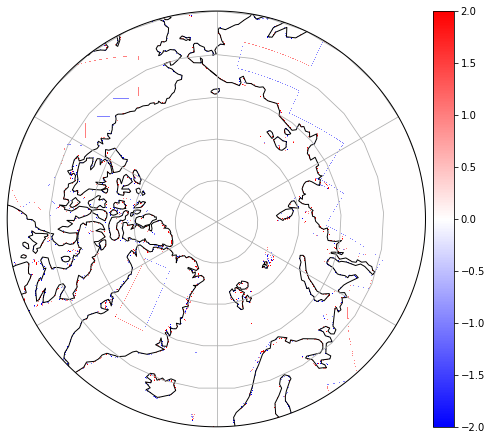

In [13]:
fig, ax = plot.field_from_dataset(ds.ULON, ds.ULAT, unBeachTot, polar=True, latRange=(60,90), size=(8,8), colormap = 'bwr')

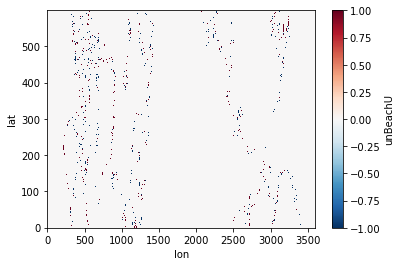

In [21]:
ds.unBeachU.plot()

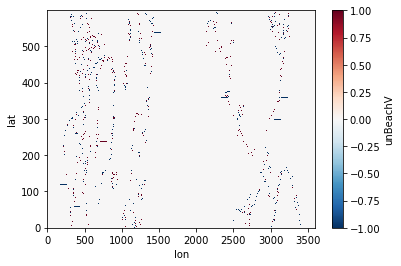

In [22]:
ds.unBeachV.plot()